## This notebook may be used to reproduce Figures 2A-D, and Figure 6 (top-left (6A), top-right (6B)) and Figure 4 in the main paper.

### Parameter values that need to be changed to derive the different figures are mentioned in comments as appropriate. Note that nonlinear and linear versions of the interneuronal inhibition model can be chosen.

### The notebook makes use of `ipyparallel`, a Python library for running calcultions in parallel, to speed up computations.

In [1]:
import ipyparallel as ipp
clients = ipp.Client()

In [2]:
clients.ids

[0, 1, 2, 3]

In [3]:
dview = clients.direct_view()

In [4]:
with dview.sync_imports():
    import numpy as np
    from math import exp,sqrt,log
    import numpy.random
%px np = numpy
%px rand = numpy.random

importing numpy on engine(s)
importing exp,sqrt,log from math on engine(s)
importing numpy.random on engine(s)


## The following cell contains the algorithm of the behaving animal

In [5]:
def Sim_Anim_Beh(trials,randSeed,rin):
    
    rand.seed(randSeed)
    
    ##############################################################################################
    # Runge_Kutta 4th-order
    ##############################################################################################
    def rk4(F,t,y,ht):
        K0 = ht*F(t,y,dfct)
        K1 = ht*F(t + ht/2.0, y + K0/2.0,dfct)
        K2 = ht*F(t + ht/2.0, y + K1/2.0,dfct)
        K3 = ht*F(t + ht, y + K2,dfct)
        return (K0 + 2.0*K1 + 2.0*K2 + K3)/6.0

    ####################################################
    # Predictor-corrector integration routine: Heun for stochastic differential equations
    ####################################################
    # time t
    # time step ht
    # number of equations (=dimensionality) n
    # random numbers xi
    # deterministic and stochastic contributons Fdet and Frand
    def Heun(Fdet, Frand,t,y,ht):
        fd1 = np.zeros(3)
        fd2 = np.zeros(3)
        fr = np.zeros(3)
        yt = np.zeros(3)
        fd1 = Fdet(t,y,dfct)
        fr = Frand()
        yt = y + ht*fd1 + fr*sqrt(ht)
        fd2 = Fdet(t+ht,yt,dfct)
        ht2 = ht/2.0
        return ht2*(fd1+fd2) + fr*sqrt(ht)
    
    #activation function
    def actfct(z,g,b):
        return 1/(1+exp(-g*(z-b)))

    #differential equations motivations
    #determnistic part
    
    
    #nonlinear model
    #use this model for Figs 2A-D, Fig 4 and Figs 6 top-left and 6 top-right (and comment out linear model below)
    def Fdet(t,y,dfct):
        Fdet = np.zeros(3)
        Fdet[0] = -k*y[0] + beta*r*actfct(y[0],g1,b1) - beta*actfct(y[2],g2,b2) + q*dfct[0]
        Fdet[1] = -k*y[1] + beta*r*actfct(y[1],g1,b1) - beta*actfct(y[2],g2,b2) + q*dfct[1]
        Fdet[2] = -kinh*y[2] + w_exc*(actfct(y[0],g1,b1) + actfct(y[1],g1,b1))
        return Fdet
    
    '''  
    #linear model
    # use this model for Figs 4E and F (and comment nonlinear model above)
    def Fdet(t,y,dfct):
        Fdet = np.zeros(3)
        Fdet[0] = (r*beta*g1/4-k)*y[0] - beta*g2/4*y[2] + q*dfct[0] + phi
        Fdet[1] = (r*beta*g1/4-k)*y[1] - beta*g2/4*y[2] + q*dfct[1] + phi
        Fdet[2] = -kinh*y[2] + w_exc*(1 - g1*b1/2 + g1/4*(y[0] + y[1]))
        return Fdet
    '''
    
    def FrandDet():
        FrandDet = np.zeros(3)
        return FrandDet
    
    
    
    # stochastic part of RHS   
    def Frand():
        Frand = np.zeros(3)
        xRand0 = rand.normal(0,1)
        xRand1 = rand.normal(0,1)
        Frand[0] = sigma*xRand0
        Frand[1] = sigma*xRand1
        Frand[2] = 0
        return Frand
    
    # model parameters
    k = 0.8 # leak excitatory unit
    kinh = 0.8 # leak inhibitory unit
    w_exc = 3 # excitation strength inhibitory unit
    q = 0.1 # frequency of integration
    g1 = 10 # gain excitation function
    g2 = 10 # gain inhibition function
    b1 = 0.5 # midpoint excitation function
    b2 = 0.5 # midpoint inhibition function
    beta = 3 #3 # inhibition strength
    r = rin
    
    #phi for linear model
    #phi = 0.5*beta*(r*(1 - g1*b1/2) - (1 - g2*b2/2))
    
    # geometric distribution for bout times
    # probability of interruption
    # calculation of maximum terminal bout time 'bout_max_99' including 99 percent of all values
    lam_interrupt = 0.05
    bout_max_99 = int(log(0.01)/log(1-lam_interrupt)) + 1
    
    eps_offset = 1e-9
    decay = 0.15
    
    ## for Fig2 (nonlinear model) choose:
    d01 = 7.5
    ## for Fig 5B (nonlinear model) choose:
    #d01 = 8.0
    ## for Fig 5C (nonlinear model), 5E (linear model) choose:
    #d01 = 8.1
    ## for Fig 5F (linear model) choose:
    #d01 = 8.35
    
    d02 = np.sqrt(2*7.5*7.5-d01**2) 
    #dfct_start = 7.5
    t = 0.0  #start time
    tend = 200  #terminal time 
    y = np.array([0.0, 0.0, 0.0])  #initial conditions
    dfct = np.array([d01, d02])
    ht = 0.005  #time step
    sigma = 0
    time1 = []  
    Ysol1 = []
    time1.append(t)
    Ysol1.append(y)

    while t <= tend:
        #ht = min(ht,tend-t)
        #y = y + Heun(Fdet,FrandDet,t,y,%%html)
        y = y + rk4(Fdet,t,y,ht)
        for ii in range(len(y)):
            y[ii] = max(0, y[ii])
        t = t + ht
        time1.append(t)
        Ysol1.append(y)
    
    y_init = y
    dfct_init = dfct
        
    Ep_sum_av = 0
    time2_list = []
    Ysol2_list = []
    Deficit_list = []
    
    for nn in range(trials):
        tau_dist = 4.0 #time to overcome distance between food and water sources
        t = 0.0
        tau = tau_dist/2.0 #initially animal is in between the two sources
        tchange = 0.0
        sigma = 0.01
        nfood = 2
        nwater = 2

        Tep = []
        Ep = []
        Ep_sum = 0
        time2 = []  
        Ysol2 = []
        Deficit = []
        time2.append(t)
        Ysol2.append(y)
        Deficit.append(dfct)
        Tbout_max = bout_max_99
        tchange_list=[]
        
        tend = Tbout_max + 1
        while t <= tend:
            for kk in range(1,Tbout_max+1):
                if t > kk-ht/2 and t < kk+ht/2:
                    Tep.append(int(t+ht))
                    penalty = dfct[0]*dfct[0] + dfct[1]*dfct[1]
                    Ep.append(penalty*lam_interrupt*pow(1-lam_interrupt,int(t+ht)-1))
            
            
            if y[0] == y[1]:
                randNr = rand.uniform(0,1)
                if randNr < 0.5:
                    y[0] = y[0] + eps_offset
                else:
                    y[1] = y[1] + eps_offset
                    
            dely1 = y[0] - y[1]
            
            if y[0] > y[1]:
                if t > tchange + tau: 
                    dfct[0] = dfct[0] - decay*ht  
                    nfood = 1
                    nwater = 0
            elif y[1] > y[0]:
                if t > tchange + tau: 
                    dfct[1] = dfct[1] - decay*ht 
                    nwater = 1
                    nfood = 0   
                
            
            for jj in range(len(dfct)):
                dfct[jj] = max(0, dfct[jj])
            
            y = y + Heun(Fdet,Frand,t,y,ht)
            for ii in range(len(y)):
                y[ii] = max(0, y[ii])
                
            if y[0] == y[1]:
                randNr = rand.uniform(0,1)
                if randNr < 0.5:
                    y[0] = y[0] + eps_offset
                else:
                    y[1] = y[1] + eps_offset
                    
            dely2 = y[0] - y[1]
            
            if np.sign(dely1)*np.sign(dely2) < 0:
                tchange_old = tchange
                tchange = t
                
                tchange_list.append(tchange)
                if nfood == 1 or nwater == 1:
                    tau = tau_dist
                    nfood = 0
                    nwater = 0
                else:
                    tau = tau_dist-tau + tchange-tchange_old
            
            t = t + ht
            dfct = np.array([dfct[0], dfct[1]])
            Deficit.append(dfct)
            time2.append(t)
            Ysol2.append(y)
        
        time2_list = time2_list + time2
        Ysol2_list = Ysol2_list + Ysol2
        Deficit_list = Deficit_list + Deficit
        Ep_sum = np.sum(Ep)
        Ep_sum_av += Ep_sum/trials
        y = y_init
        dfct = dfct_init
    
    time2_av = []
    Ysol2_av = []
    Deficit_av = []
    for kk in range(len(time2)):
        time2_av.append(np.sum(time2_list[kk::len(time2)])/trials)
        Ysol2_av.append(sum(Ysol2_list[kk::len(time2)])/trials)
        Deficit_av.append(sum(Deficit_list[kk::len(time2)])/trials)
    return Ep_sum_av,time1,Ysol1,time2_av,Ysol2_av,Deficit_av,tau_dist,tchange_list

In [6]:
rlist = [0.5,1,1.5,2]
#rlist = [1,1,1,1]

import timeit
time_start = timeit.default_timer()
nr_engines = len(clients.ids)
randSeedList = [(jj+1)*1928374 for jj in range(nr_engines)]
nr_trials_tot = 4
nr_trials_per_engine = int(nr_trials_tot/nr_engines)
results = dview.map_sync(Sim_Anim_Beh, [nr_trials_per_engine]*nr_engines, randSeedList, rlist)
time_stop = timeit.default_timer()
print('elapsed time =',time_stop - time_start,'seconds')
#print(randSeedList)

elapsed time = 11.244370896369219 seconds


In [7]:
time1 = results[0][1]  

## for r=1  (Fig2A) choose:
Ysol1 = results[1][2]
## for r=2  (Fig2D) choose:
#Ysol1 = results[3][2]

time2 = results[0][3]
Ep_sum_av = 0
Ysol2 = [0]*len(time2)
Deficit = [0]*len(time2)
for kk in range(nr_engines):
    Ep_sum_av += results[kk][0]/nr_engines
for jj in range(len(time2)):
    for kk in range(nr_engines):
        Ysol2[jj] += results[kk][4][jj]/nr_engines
        Deficit[jj] += results[kk][5][jj]/nr_engines
        

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

## The following lines in this cell may be used to see the evolution of initial conditions

<IPython.core.display.Javascript object>


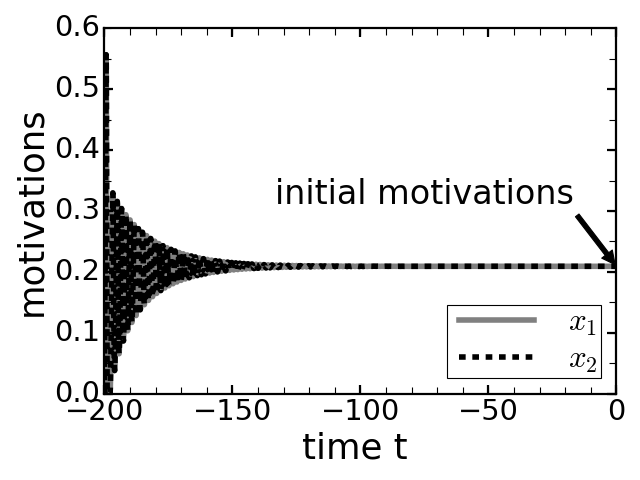

In [9]:
fig1=plt.figure(figsize=(8,6))
plt.plot(np.asarray(time1)-200,np.asarray(Ysol1)[:,0],c = '0.5', ls ='-',lw = 5,label = r'$x_1$')
plt.plot(np.asarray(time1)-200,np.asarray(Ysol1)[:,1],c = '0', ls = '--', lw = 5,label = r'$x_2$')
plt.legend(loc='lower right', frameon=True, handlelength=3, borderpad=0.1, labelspacing=0.2, fontsize=28)
ax = plt.axes()
plt.xlabel(r'time t ', fontsize=32)
plt.ylabel(r'motivations', fontsize=32)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26)
#plt.tick_params(labelsize=14)
plt.xlim(-200,0)
plt.ylim(0,0.6)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params('both', length=8, width=2, which='major')
ax.tick_params('both', length=6, width=1, which='minor')

ax.annotate(r'initial motivations', xy=(0, np.asarray(Ysol1)[-1,0]), xytext=(-75, 0.3), fontsize=30,
            arrowprops=dict(facecolor='k', edgecolor='k', shrink=0.03),
            horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout();

## The following is relevant for Figs 2 and 6

<IPython.core.display.Javascript object>


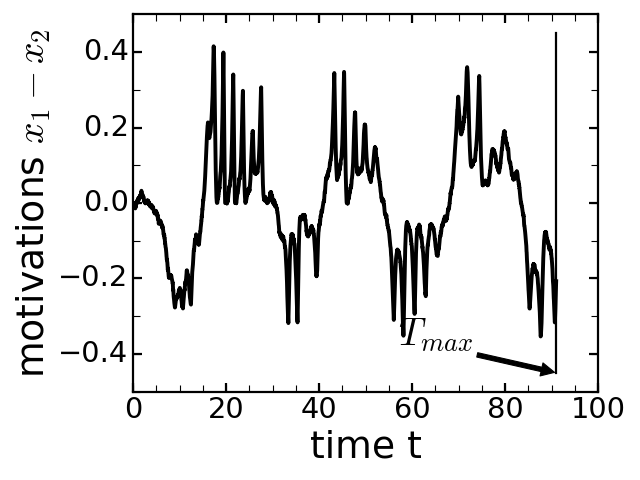

In [11]:
fig2 = plt.figure(figsize=(8,6))
#fig2 = plt.figure(figsize=(12,6)) #for use with legend
freq = 5
freq_marker=350
freq_marker2=100
freq_marker3=20

## to reproduce Fig2 choose:
## for r=1 (Fig2A):
plt.plot(time2[0:-1:freq],np.asarray(results[1][4])[0:-1:freq,0]-np.asarray(results[1][4])[0:-1:freq,1],c = 'k',lw = 3.5, ls='-')
## for r=2 (Fig2B):
#plt.plot(time2[0:-1:freq],np.asarray(results[3][4])[0:-1:freq,0]-np.asarray(results[3][4])[0:-1:freq,1],c = 'k',lw = 3.5, ls='-')

'''
## to reproduce Fig6 choose:
plt.plot(time2[0:-1:freq],np.asarray(results[1][4])[0:-1:freq,0]-np.asarray(results[1][4])[0:-1:freq,1],c = '0.56',lw = 3, ls='-', label=r'$r=1.0$')
plt.plot(time2[0:-1:freq_marker3],np.asarray(results[1][4])[0:-1:freq_marker3,0]-np.asarray(results[1][4])[0:-1:freq_marker3,1],c = '0.56',marker='o', ms=16, ls='None',  label=r'$r=1.0$')
plt.plot(time2[0:-1:freq],np.asarray(results[0][4])[0:-1:freq,0]-np.asarray(results[0][4])[0:-1:freq,1],c = '0',lw = 3, ls='-', label=r'$r=0.5$')
plt.plot(time2[0:-1:freq_marker2],np.asarray(results[0][4])[0:-1:freq_marker2,0]-np.asarray(results[0][4])[0:-1:freq_marker2,1],c = '0', marker='d', ms=20, ls='None', mec='1', mew=1)
plt.plot(time2[0:-1:freq],np.asarray(results[2][4])[0:-1:freq,0]-np.asarray(results[2][4])[0:-1:freq,1],c = '0.28',lw = 3, ls='-', label=r'$r=1.5$')
plt.plot(time2[0:-1:freq_marker],np.asarray(results[2][4])[0:-1:freq_marker,0]-np.asarray(results[2][4])[0:-1:freq_marker,1],c = '0.28',marker='>', ms=24, ls='None', mec='1', mew=1, label=r'$r=1.5$')
plt.plot(time2[0:-1:freq],np.asarray(results[3][4])[0:-1:freq,0]-np.asarray(results[3][4])[0:-1:freq,1],c = '0.84',lw = 3, ls='-', label=r'$r=2.0$')
plt.plot(time2[0:-1:freq_marker],np.asarray(results[3][4])[0:-1:freq_marker,0]-np.asarray(results[3][4])[0:-1:freq_marker,1],c = '0.84',marker='*', ms=28, ls='None',  label=r'$r=2.0$')
'''
ax = plt.axes()
plt.xlabel(r'time t', fontsize=34)
plt.ylabel(r'motivations $x_1-x_2$', fontsize=34)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26)
plt.xlim(0,100)

##for Fig2B choose:
plt.ylim(-0.5,0.5)
##for Fig2E choose:
#plt.ylim(-0.04,0.06)

#plt.text(40, 0.4, r'water', fontsize=28, color = 'blue')
#plt.text(40, -0.4, r'food', fontsize=28, color = 'green')
#plt.text(61, 0.77, r'max. terminal', fontsize=24)
#plt.text(82, 0.64, r'time', fontsize=24)
#plt.plot((0, 100), (0, 0), c = 'grey', ls = 'dashed', lw = 3)
#ax.fill_between([0, 100], 0, 0.5, facecolor='g', alpha=0.1)
#ax.fill_between([0, 100], 0, -0.5, facecolor='b', alpha=0.1)

plt.plot((91, 91), (-0.45, 0.45), c = 'k', ls = '-', lw = 2)

#ax.arrow(91, 0.6, 0, -1.5, head_width=2, head_length=0.1, fc='k', ec='k',lw=2.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params('both', length=8, width=2, which='major')
ax.tick_params('both', length=6, width=1, which='minor')

ax.annotate(r'$T_{max}$', xy=(91, -0.45), xytext=(65, -0.4), fontsize=34,
            arrowprops=dict(facecolor='k', edgecolor='k', shrink=0.02),
            horizontalalignment='center', verticalalignment='bottom')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

'''    
#customise legend
legend_elements_models = [Line2D([0], [0], color='0', marker='d', ms=24, 
                                 markeredgewidth = 1, markeredgecolor='1', ls='-', lw=4.5, label=r'$r=0.5$'),
                          Line2D([0], [0], color='0.56', marker='o', ms=20, 
                                markeredgewidth = '1', ls='-', lw=4.5, label=r'$r=1.0$'),
                          Line2D([0], [0], color='0.28', marker='>', ms=24, 
                                 markeredgewidth = 1, markeredgecolor='1', ls='-', lw=4.5, label=r'$r=1.5$'),
                          Line2D([0], [0], color='0.84', marker='*', ms=28, 
                                 markeredgewidth = 1, ls='-', lw=4.5, label=r'$r=2.0$')]
leg1 = ax.legend(handles = legend_elements_models, loc='center left', bbox_to_anchor=(-0.2, 1.15), ncol=4, 
           shadow=False, fancybox=True, columnspacing=1, handlelength=2.5,fontsize=30,
                 handletextpad=0.25,numpoints=3,borderpad=0.2)
'''
#Shrink current axis 
#box = ax.get_position()
#ax.set_position([box.x0+0.05, box.y0+0.05, box.width, box.height* 0.84])
## Uncomment legend for Fig 4
#plt.legend(bbox_to_anchor=(0.4, 1), loc='upper center', ncol=1, fontsize=18, handlelength=3, fancybox=True, borderpad=0.4, 
#           labelspacing=0.2)

plt.tight_layout();

In [ ]:
#fig2.savefig("Fig6_topLeft_withLegend.pdf")
#fig2.savefig("Fig6_topLeft.pdf")
#fig2.savefig("Fig6_topRight.pdf")
#fig2.savefig("Fig2A.pdf")
#fig2.savefig("Fig2B.pdf")

## The following cells produce Fig 4 

### It takes decisin time intervals from a single trial generated in this notbook and compares it with decision time intervals generated in the notebook:   `SimExampleMotivationChangesAverage.ipynb`   in the same folder

In [122]:
import csv
from scipy import stats

In [123]:
diffThresh=0.5
results_r1_combined=[]
with open("motivChanges_diffThresh"+str(diffThresh)+"_r_eq_1.csv", "r") as inf1:
    reader = csv.reader(inf1)
    for row in reader:
        row2 = [float(row[kk]) for kk in range(len(row))]
        results_r1_combined.append(row2) 
results_r1=[np.asarray([y - x for x,y in zip(results_r1_combined[jj],results_r1_combined[jj][1:])]) for jj in range(len(results_r1_combined))]
results_r1_mod=[results_r1[jj][results_r1[jj]>diffThresh] for jj in range(len(results_r1))]
results_r1_len=[len(results_r1_mod[jj]) for jj in range(len(results_r1_mod))]
results_r1_maxLen = np.max(results_r1_len)
results_r1_minLen = np.min(results_r1_len)
print(results_r1_maxLen)
print(results_r1_minLen)
results_r1_mod=np.asarray([(list(results_r1_mod[jj]) + results_r1_maxLen * [0])[:results_r1_maxLen] for jj in range(len(results_r1_mod))])
results_r1_av_calc=[0]*results_r1_maxLen
count_r1=[0]*results_r1_maxLen
for term in results_r1_mod:
    for jj in range(results_r1_maxLen):
        if term[jj]!=0:
            count_r1[jj]+=1
            results_r1_av_calc[jj]+=term[jj]
results_r1_av_calc=np.asarray(results_r1_av_calc)/np.asarray(count_r1)
results_r1_std_calc=[0]*results_r1_maxLen
for term in results_r1_mod:
    for jj in range(results_r1_maxLen):
        if term[jj]!=0:
            results_r1_std_calc[jj]+=(term[jj]-results_r1_av_calc[jj])**2
results_r1_std_calc=np.sqrt(np.asarray(results_r1_std_calc)/np.asarray(count_r1))
results_r1_sem_calc=results_r1_std_calc/np.sqrt(np.asarray(count_r1))
studentT_r1 = stats.t.ppf(1-0.025, np.asarray(count_r1))  #Studnt, n=Nr_Trials, p<0.05, 2-tail, i.e. 95% confidence interval
errors_r1=studentT_r1*results_r1_sem_calc
#print(results_r1_av_calc)    
#print(results_r1_std_calc)
#print(results_r1_sem_calc)
#print(studentT_r1)
#print(errors_r1)
#print(count_r1)
results_r1_av=np.mean(results_r1_mod, axis=0)
results_r1_std=np.std(results_r1_mod, axis=0)
#print(results_r1_av)
#print(results_r1_std)

results_r2_combined=[]
with open("motivChanges_diffThresh"+str(diffThresh)+"_r_eq_2.csv", "r") as inf2:
    reader = csv.reader(inf2)
    for row in reader:
        row2 = [float(row[kk]) for kk in range(len(row))]
        results_r2_combined.append(row2)
results_r2=[np.asarray([y - x for x,y in zip(results_r2_combined[jj],results_r2_combined[jj][1:])]) for jj in range(len(results_r2_combined))]
results_r2_mod=[results_r2[jj][results_r2[jj]>diffThresh] for jj in range(len(results_r2))]
results_r2_len=[len(results_r2_mod[jj]) for jj in range(len(results_r2_mod))]
results_r2_maxLen = np.max(results_r2_len)
results_r2_minLen = np.min(results_r2_len)
print(results_r2_maxLen)
print(results_r2_minLen)
results_r2_mod=np.asarray([(list(results_r2_mod[jj]) + results_r2_maxLen * [0])[:results_r2_maxLen] for jj in range(len(results_r2_mod))])
results_r2_av_calc=[0]*results_r2_maxLen
count_r2=[0]*results_r2_maxLen
for term in results_r2_mod:
    for jj in range(results_r2_maxLen):
        if term[jj]!=0:
            count_r2[jj]+=1
            results_r2_av_calc[jj]+=term[jj]
results_r2_av_calc=np.asarray(results_r2_av_calc)/np.asarray(count_r2)
results_r2_std_calc=[0]*results_r2_maxLen
for term in results_r2_mod:
    for jj in range(results_r2_maxLen):
        if term[jj]!=0:
            results_r2_std_calc[jj]+=(term[jj]-results_r2_av_calc[jj])**2
results_r2_std_calc=np.sqrt(np.asarray(results_r2_std_calc)/np.asarray(count_r2))
results_r2_sem_calc=results_r2_std_calc/np.sqrt(np.asarray(count_r2))
studentT_r2 = stats.t.ppf(1-0.025, np.asarray(count_r2))  #Studnt, n=Nr_Trials, p<0.05, 2-tail, i.e. 95% confidence interval
errors_r2=studentT_r2*results_r2_sem_calc
results_r2_av=np.mean(results_r2_mod, axis=0)
#print(results_r2_av)

15
6
49
17


<IPython.core.display.Javascript object>


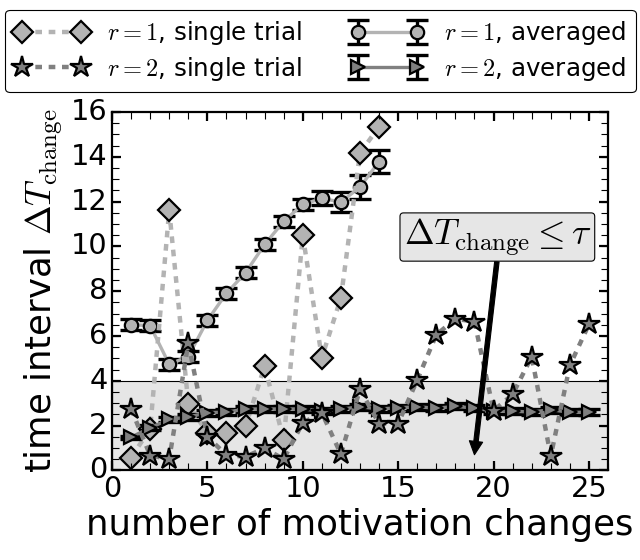

In [124]:
##The following produces Fig. 4

decTimes_r1=results[1][7] #corresponds to Fig2B
decTimesDiff_r1=np.asarray([y - x for x,y in zip(decTimes_r1,decTimes_r1[1:])])
decTimesDiffMod_r1=decTimesDiff_r1[decTimesDiff_r1>diffThresh]
decTimes_r2=results[3][7] #corresponds to Fig2E
decTimesDiff_r2=np.asarray([y - x for x,y in zip(decTimes_r2,decTimes_r2[1:])])
decTimesDiffMod_r2=decTimesDiff_r2[decTimesDiff_r2>diffThresh]

figExtra = plt.figure(figsize=(8,7))
ax = plt.axes()

plt.fill_between(np.arange(len(decTimesDiffMod_r2)+2),0,4,facecolor='0.9')

yerr1 = errors_r1[:len(decTimesDiffMod_r1)]
ax.errorbar(np.arange(len(decTimesDiffMod_r1))+1, results_r1_av_calc[:len(decTimesDiffMod_r1)], yerr=yerr1, 
             color='0.7', ls='-', lw=3, marker='o', ms=12, mfc='0.7', mec='0', mew=2,
             capsize= 10, capthick=3, elinewidth=3, ecolor='k', barsabove=False, label=r'$r=1$, averaged')
plt.plot(np.arange(len(decTimesDiffMod_r1))+1,decTimesDiffMod_r1,
        color='0.7', ls='--', lw=4, marker='D', ms=14, mfc='0.7', mec='0', mew=2, label=r'$r=1$, single trial')
#plt.plot(np.arange(len(results_r1_av))+1,results_r1_av)
#plt.plot(np.arange(len(decTimesDiffMod_r1))+1,results_r1_av_calc[:len(decTimesDiffMod_r1)])

yerr2 = errors_r2[:len(decTimesDiffMod_r2)]
ax.errorbar(np.arange(len(decTimesDiffMod_r2))+1, results_r2_av_calc[:len(decTimesDiffMod_r2)], yerr=yerr2, 
             color='0.5', ls='-', lw=3, marker='>', ms=12, mfc='0.5', mec='0', mew=2,
             capsize= 10, capthick=3, elinewidth=3, ecolor='k', barsabove=False, label=r'$r=2$, averaged')
plt.plot(np.arange(len(decTimesDiffMod_r2))+1,decTimesDiffMod_r2,
        color='0.5', ls='--', lw=4, marker='*', ms=20, mfc='0.5', mec='0', mew=2, label=r'$r=2$, single trial')
#plt.plot(np.arange(len(decTimesDiffMod_r2))+1,decTimesDiffMod_r2, ls='--')
#plt.plot(np.arange(len(results_r2_av))+1,results_r2_av, ls='--')
#plt.plot(np.arange(len(decTimesDiffMod_r2))+1,results_r2_av_calc[:len(decTimesDiffMod_r2)], ls='--')

plt.xlabel(r'number of motivation changes', fontsize=32)
plt.ylabel(r'time interval $\Delta T_{\mathrm{change}}$', fontsize=32)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26)
#plt.tick_params(labelsize=14)
#plt.xlim(-200,0)
plt.xlim(0,len(decTimesDiffMod_r2)+1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params('both', length=8, width=2, which='major')
ax.tick_params('both', length=6, width=1, which='minor')

#Shrink current axis 
box = ax.get_position()
ax.set_position([box.x0+0.05, box.y0+0.06, box.width, box.height* 0.8])
plt.legend(bbox_to_anchor=(0.42, 1.32), loc='upper center', ncol=2, fontsize=22, 
           handlelength=3, fancybox=True, borderpad=0.4, labelspacing=0.3)

bbox = dict(boxstyle="round", fc="0.9", pad=0.1)
ax.annotate(r'$\Delta T_{\mathrm{change}}\leq \tau$',  xy=(19, 0.7), xytext=(20.2, 9.5), fontsize=32,
            arrowprops=dict(facecolor='k', edgecolor='k', shrink=0.0),
            horizontalalignment='center', verticalalignment='bottom', bbox=bbox)

#plt.tight_layout();

In [ ]:
#figExtra.savefig("Fig4.eps")

## The following is only relevant for Figs 2C&D

<IPython.core.display.Javascript object>


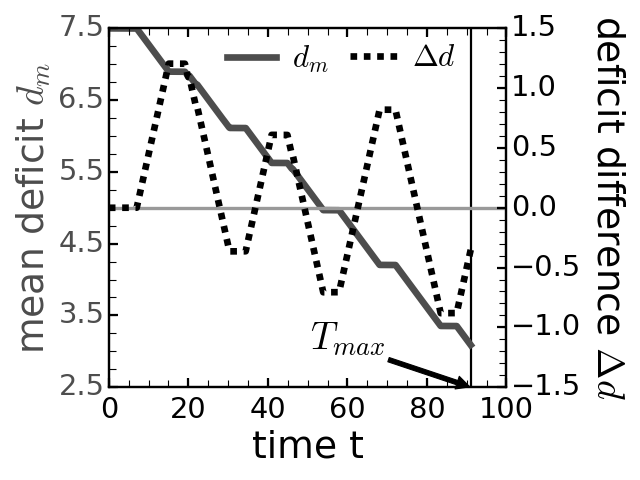

In [138]:
fig4, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()

color1='0'
color2='0.3'
color3='0.6'
##########################
chooseR = 1 # 1 or 2
##########################
if chooseR==1: # Fig2C
    meanD = 0.5*(np.asarray(results[1][5])[:,0] + np.asarray(results[1][5])[:,1])
    diffD = np.asarray(results[1][5])[:,0] - np.asarray(results[1][5])[:,1]
elif chooseR==2: # Fig2D
    meanD = 0.5*(np.asarray(results[3][5])[:,0] + np.asarray(results[3][5])[:,1])
    diffD = np.asarray(results[3][5])[:,0] - np.asarray(results[3][5])[:,1]

ax1.plot((91, 91), (0.5, 7.5), c = 'k', ls = '-', lw = 2)
ax2.plot((0, 100), (0, 0), c = color3, ls = '-', lw = 3)
ax1.plot(np.asarray(time2), meanD, c = color2, lw = 6, label=r'$d_m$')
ax2.plot(np.asarray(time2), diffD, c = color1, lw = 6, ls='--', label=r'$\Delta d$')

ax1.set_xlabel(r'time t', fontsize=34, color=color1)
ax1.set_ylabel(r'mean deficit $d_m$', fontsize=34, color=color2)
ax2.set_ylabel(r'deficit difference $\Delta d$', fontsize=34, color=color1, rotation=-90, labelpad=40)

#for tick in ax1.xaxis.get_major_ticks():
#    tick.label.set_fontsize(26) 
#for tick in ax1.yaxis.get_major_ticks():
#    tick.label.set_fontsize(26)
#for tick in ax2.yaxis.get_major_ticks():
#    tick.label.set_fontsize(26)

    #plt.text(61, 4.62, r'max. terminal', fontsize=24)
#plt.text(82, 4.4, r'time', fontsize=24)
#ax.arrow(91, 4.3, 0, -2.22, head_width=2, head_length=0.07, fc='k', ec='k',lw=2.5)
#plt.tick_params(labelsize=14)


ax1.set_xlim(0,100)
ax1.set_ylim(2.5,7.5)
ax2.set_ylim(-1.5,1.5)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax1.yaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0))
ax1.yaxis.set_minor_locator(ticker.IndexLocator(base=0.25,offset=0))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)
    ax2.spines[axis].set_linewidth(2)

ax1.tick_params('x', length=8, width=2, which='major', labelsize=26, direction='in', pad=8)
ax1.tick_params('x', length=6, width=1, which='minor')
ax1.tick_params('y', length=8, width=2, which='major', labelsize=26, direction='in', labelcolor=color2)
ax1.tick_params('y', length=6, width=1, which='minor')
ax2.tick_params('y', length=8, width=2, which='major', labelsize=26, direction='in')
ax2.tick_params('y', length=6, width=1, which='minor')

ax1.annotate(r'$T_{max}$', xy=(91, 2.5), xytext=(60, 2.9), fontsize=34,
            arrowprops=dict(facecolor='k', edgecolor='k', shrink=0.01),
            horizontalalignment='center', verticalalignment='bottom')

if chooseR==1:
    ax1.legend(bbox_to_anchor=(0.6, 1.01), frameon=False, handlelength=2.2, borderpad=0.1, labelspacing=0.2, 
               handletextpad=0.2, fontsize=28)
    ax2.legend(bbox_to_anchor=(0.92, 1.01), frameon=False, handlelength=2.2, borderpad=0.1, labelspacing=0.2, 
               handletextpad=0.1, fontsize=28)
elif chooseR==2:
    ax1.legend(bbox_to_anchor=(0.92, 1.01), frameon=False, handlelength=2.2, borderpad=0.1, labelspacing=0.2, 
               handletextpad=0.2, fontsize=28)
    ax2.legend(bbox_to_anchor=(0.92, 0.9), frameon=False, handlelength=2.2, borderpad=0.1, labelspacing=0.2, 
               handletextpad=0.1, fontsize=28)
fig4.tight_layout();

In [139]:
#fig4.savefig("Fig2C.pdf")
#fig4.savefig("Fig2D.pdf")

## The following produce the temporal evoultion of the deficits d_1(t) and d_2(t)

<IPython.core.display.Javascript object>


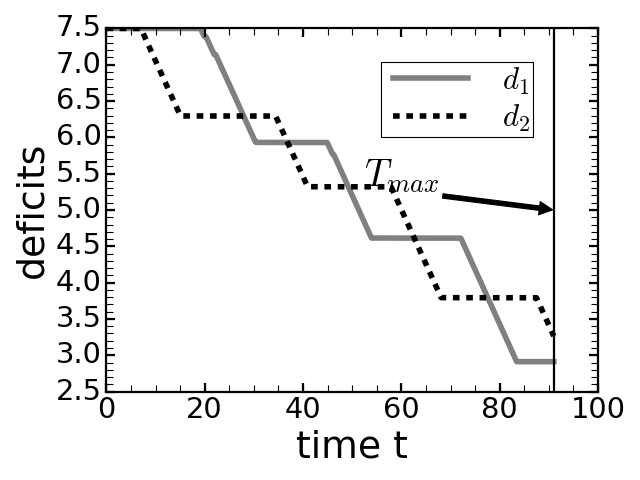

In [12]:
fig3=plt.figure(figsize=(8,6))

## for Fig2 choose:
## for r=1 (Fig2C):
plt.plot(np.asarray(time2),np.asarray(results[1][5])[:,0],c = '0.5',lw = 5, label=r'$d_1$')
plt.plot(np.asarray(time2),np.asarray(results[1][5])[:,1],c = '0',lw = 5, ls='--', label=r'$d_2$')
## for r=2 (Fig2D):
#plt.plot(np.asarray(time2),np.asarray(results[3][5])[:,0],c = '0.5',lw = 5, label=r'$d_1$')
#plt.plot(np.asarray(time2),np.asarray(results[3][5])[:,1],c = '0',lw = 5, ls='--', label=r'$d_2$')

#plt.plot(np.asarray(time2),np.asarray(Deficit)[:,0],c = 'b',lw = 3.5)
#plt.plot(np.asarray(time2),np.asarray(Deficit)[:,1],c = 'r',lw = 3.5)

ax = plt.axes()
plt.xlabel(r'time t', fontsize=34)
plt.ylabel(r'deficits', fontsize=34)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26)
#plt.text(61, 4.62, r'max. terminal', fontsize=24)
#plt.text(82, 4.4, r'time', fontsize=24)
#ax.arrow(91, 4.3, 0, -2.22, head_width=2, head_length=0.07, fc='k', ec='k',lw=2.5)
#plt.tick_params(labelsize=14)

plt.plot((91, 91), (0.5, 7.5), c = 'k', ls = '-', lw = 2)

plt.xlim(0,100)

##for Fig2 choose:
plt.ylim(2.5,7.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params('both', length=8, width=2, which='major')
ax.tick_params('both', length=6, width=1, which='minor')

ax.annotate(r'$T_{max}$', xy=(91, 5), xytext=(60, 5.2), fontsize=34,
            arrowprops=dict(facecolor='k', edgecolor='k', shrink=0.01),
            horizontalalignment='center', verticalalignment='bottom')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.legend(bbox_to_anchor=(0.9, 0.95), frameon=True, handlelength=3, borderpad=0.1, labelspacing=0.2, fontsize=28)
plt.tight_layout();